**VGG16 Transfer Learning**

[VERY DEEP CONVOLUTIONAL NETWORKS FOR LARGE-SCALE IMAGE RECOGNITION arxiv.org/pdf](https://arxiv.org/pdf/1409.1556.pdf)

During training, the input to our ConvNets is a fixed-size 224 × 224 RGB image.
The only preprocessing we do is subtracting the mean RGB value, computed on the training set, from each pixel.
The image is passed through a stack of convolutional (conv.) layers, where we use filters with a very
small receptive field: 3 × 3 (which is the smallest size to capture the notion of left/right, up/down,
center).

**Import des librairies**

In [1]:
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.applications.vgg16 import VGG16

from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from tensorboard.plugins.hparams import api as hp

import datetime
import itertools
import os
import shutil
import random
import glob

In [2]:
%load_ext tensorboard

**Parametres CUDA pour modélisation en local**

In [3]:
# Installer CUDA, CUDNN
gpus = tf.config.experimental.list_physical_devices('GPU')

for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

print("Nombre de GPU disponible : ", len(gpus))

Nombre de GPU disponible :  1


**Parametres divers**

In [4]:
BATCH_SIZE = 10
N_EPOCHS = 150

#ADAM_LEARNING_RATE = 0.0003
PATIENCE_ES = 4

VALIDATION_RATIO = 0.2
TEST_RATIO = 0.1
TRAIN_RATIO = 1 - VALIDATION_RATIO - TEST_RATIO

N_BREEDS = 20
N_IMAGE_PER_CLASS = 140
IMG_HEIGHT = 224
IMG_WIDTH = 224

RANDOM_STATE = 42

**On fixe la randomness pour la répétabilité de l'experience**

In [5]:
random.seed(RANDOM_STATE)

**Préparation des dossiers pour la génération d'images et l'augmentation**

In [6]:
# On se déplace dans le dossier images
os.chdir('data/images')

In [7]:
# On supprimer les dossiers de modélisations et leurs contenus si déjà éxistants dans images
_ = [shutil.rmtree(path) for path in ["train","valid","test"] if os.path.isdir(path) is True ]

In [8]:
# On recuperer les races (subdirectories)
list_dir_breeds = os.listdir()

In [9]:
# On observe le nombre d'images pour chaque races dans leur dossier respectifs à l'aide d'un dataframe
df_breds = pd.DataFrame([[f"{path:40}",len(os.listdir(path))] for path in list_dir_breeds] , columns=["race", "nombre_images"])
df_breds

,race,nombre_images
0,n02085620-Chihuahua,152
1,n02085782-Japanese_spaniel,185
2,n02085936-Maltese_dog,252
3,n02086079-Pekinese,149
4,n02086240-Shih-Tzu,214
...,...,...
115,n02113799-standard_poodle,159
116,n02113978-Mexican_hairless,155
117,n02115641-dingo,156
118,n02115913-dhole,150


In [10]:
# On selectionne au hasard un nombre N de races.
list_dir_breeds = random.sample(list_dir_breeds, N_BREEDS)
list_dir_breeds

['n02106166-Border_collie',
 'n02089078-black-and-tan_coonhound',
 'n02086079-Pekinese',
 'n02108915-French_bulldog',
 'n02094258-Norwich_terrier',
 'n02093754-Border_terrier',
 'n02093256-Staffordshire_bullterrier',
 'n02090379-redbone',
 'n02088632-bluetick',
 'n02107312-miniature_pinscher',
 'n02113712-miniature_poodle',
 'n02102480-Sussex_spaniel',
 'n02088364-beagle',
 'n02105251-briard',
 'n02099267-flat-coated_retriever',
 'n02086240-Shih-Tzu',
 'n02092339-Weimaraner',
 'n02093428-American_Staffordshire_terrier',
 'n02101388-Brittany_spaniel',
 'n02105505-komondor']

Pour éviter d'augmenter les données lors de la séparation du jeu de validation de Keras avec ImageDataGenerator, il y a plusieurs techniques, je vais séparer le jeu puis créer différent ImageDataGenerator

In [11]:
# Organiser les données en un dossier d'entrainement, de validation et de test
for dir_breeds in list_dir_breeds:
    path_train = f"train/{dir_breeds}"
    path_valid = f"valid/{dir_breeds}"
    path_test = f"test/{dir_breeds}"
    
    # On crée nos dossiers vides
    [os.makedirs(path) for path in [path_train,path_valid,path_test] if os.path.isdir(path) is False]

In [12]:
# Si le nombre d'images minimum par classe est inférieur à notre paramétre on renvoit une erreur
min_images = df_breds["nombre_images"].min()
assert(min_images > N_IMAGE_PER_CLASS)

In [13]:
train_size, valid_size, test_size = [int(TRAIN_RATIO*N_IMAGE_PER_CLASS) , int(VALIDATION_RATIO*N_IMAGE_PER_CLASS), int(TEST_RATIO*N_IMAGE_PER_CLASS)]

In [14]:
# Train Test Split
for dir_breeds in list_dir_breeds:
    path_train = f"train/{dir_breeds}"
    path_valid = f"valid/{dir_breeds}"
    path_test = f"test/{dir_breeds}"
    
    # Si nos dossiers sont vides
    if len(os.listdir(path_train)+os.listdir(path_valid)+os.listdir(path_test)) == 0:

        list_path_images = os.listdir(path=dir_breeds)
        
        # On ajoute le nombre d'images choisi pour l'entrainement, la validation et le test
        for path_image in random.sample(list_path_images, train_size):
            shutil.copy(f"{dir_breeds}/{path_image}", path_train)
            list_path_images.remove(path_image)

        for path_image in random.sample(list_path_images, valid_size):
            shutil.copy(f"{dir_breeds}/{path_image}", path_valid)
            list_path_images.remove(path_image)

        for path_image in random.sample(list_path_images, test_size):
            shutil.copy(f"{dir_breeds}/{path_image}", path_test)
            list_path_images.remove(path_image)
    else:
        print("Les dossiers ne sont pas vides")
        break

In [15]:
# On revient dans le dossier root
os.chdir('../../')

In [16]:
# Chemins de nos dossiers fraichement générer
train_path = "data/images/train"
valid_path = "data/images/valid"
test_path = "data/images/test"

In [17]:
# Création des itérateurs de données pour notre modélisation
print("train batches :")
train_image_data_generator = ImageDataGenerator(rotation_range=40,
                                                width_shift_range=0.2,
                                                height_shift_range=0.2,
                                                shear_range=0.2,
                                                zoom_range=0.2,
                                                horizontal_flip=True,
                                                preprocessing_function=tf.keras.applications.vgg16.preprocess_input)
train_batches = train_image_data_generator.flow_from_directory(directory=train_path,
                                                               target_size=(IMG_HEIGHT,IMG_WIDTH),
                                                               classes=list_dir_breeds,
                                                               batch_size=BATCH_SIZE)

print("valid batches :")
valid_image_data_generator = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input)
valid_batches = valid_image_data_generator.flow_from_directory(directory=valid_path,
                                                               target_size=(IMG_HEIGHT,IMG_WIDTH),
                                                               classes=list_dir_breeds,
                                                               batch_size=BATCH_SIZE)


print("test batches :")
test_image_data_generator = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input)
test_batches = test_image_data_generator.flow_from_directory(directory=test_path,
                                                             target_size=(IMG_HEIGHT,IMG_WIDTH),
                                                             classes=list_dir_breeds,
                                                             batch_size=BATCH_SIZE,
                                                             shuffle=False)

train batches :
Found 1960 images belonging to 20 classes.
valid batches :
Found 560 images belonging to 20 classes.
test batches :
Found 280 images belonging to 20 classes.


**Visualisation de l'augmentation avant entrainement**

In [18]:
# On génére le prochain batch du train avec augmentation
imgs, labels = next(train_batches)

In [19]:
# Fonction custom pour visualiser l'augmentation
def plot_images(images_arr, labels=None, rescaled=True,print_shape=True):
    if rescaled:
        images_arr= images_arr*255.0
    size = len(images_arr)
    fig, axes = plt.subplots(1, size, figsize=(20,20))
    axes = axes.flatten()
    for i, (img, ax) in enumerate(zip( images_arr, axes)):
        img = img.astype(np.uint8)
        ax.imshow(img)
        if labels is not None:
            ax.set_title(labels[i])
        elif print_shape is True :
            ax.set_title(np.array(img).shape)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

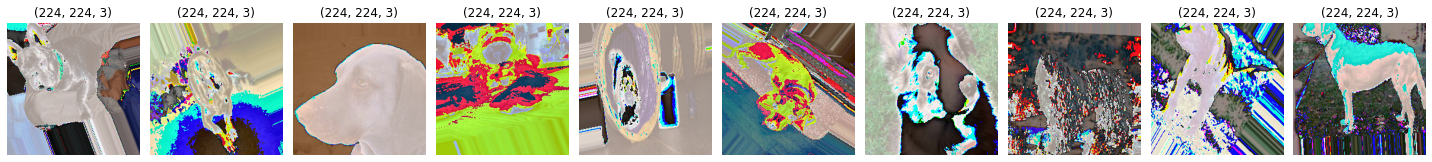

In [20]:
plot_images(imgs, print_shape=True, rescaled=False)

**Définir les paramétres du gridsearch**

In [21]:
# tensorboard utilisé pour visualiser les epochs durant training

In [22]:
# Créer les hyperparametres
HP_ADAM_LEARNING_RATE = hp.HParam("adam_learning_rate", hp.RealInterval(0.0003, 0.01))
METRIC_ACCURACY = "accuracy"

**Création et configuration des fichiers dans tensorboard**


In [23]:
log_dir = "logs/hparam_tuning_" + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')

with tf.summary.create_file_writer(log_dir).as_default():
    hp.hparams_config(
        hparams = [HP_ADAM_LEARNING_RATE,
                  ],
        metrics = [hp.Metric(METRIC_ACCURACY,
                             display_name="Accuracy")
                  ]
    )

**Fonctions pour la modélisation avec gridsearch**

In [24]:
# Fonction de modélisation avec les hyperparametres fournis

def model(hparams) :
    
    # On récupere le modele avec les poids entrainés
    model = VGG16(weights = "imagenet",
                  include_top = True
                 )
    
    # On crée notre derniere couche à partir des couches précédentes de vgg16
    last_layer = Dense(units = N_BREEDS,
                       activation ='softmax',
                       name ='predictions'
                      )(model.layers[-2].output)

    # Puis on crée notre modéle
    model = tf.keras.Model(inputs = model.input,
                           outputs = last_layer
                          )
    
    # freeze all
    for layer in model.layers:
        layer.trainable = False
    
    # unfreeze avec poids non aléatoire (experimentation)
    model.layers[-1].trainable = True
    model.layers[-2].trainable = True
    model.layers[-3].trainable = True
    
    # On compile
    model.compile(optimizer=tf.optimizers.Adam(hparams[HP_ADAM_LEARNING_RATE]),
                  loss='categorical_crossentropy',
                  metrics=['accuracy']
                 )
    
    # Définir les callbacks
    my_callbacks = [
        tf.keras.callbacks.TensorBoard(log_dir),
        hp.KerasCallback(log_dir, hparams),
        tf.keras.callbacks.EarlyStopping(monitor = "val_loss", patience = PATIENCE_ES),
        tf.keras.callbacks.ModelCheckpoint(f"model_VGG16_{N_BREEDS}_{'_'.join(str(x) for x in list(hparams.values()))}.hdf5",
                                           save_best_only=True,
                                           monitor='val_loss',
                                           mode='min')
    ]

    
    # On entraine, on récupere l'historique et on enregistre dans nos logs
    history = model.fit(x = train_batches,
                        steps_per_epoch = len(train_batches),
                        validation_data = valid_batches,
                        validation_steps = len(valid_batches),
                        epochs = N_EPOCHS,
                        verbose = 2,
                        callbacks=my_callbacks
                       )
    
    # On retourne la métrique d'optimisation
    return history.history['val_accuracy'][-1]

In [25]:
# Fonction d'enregistrement pour chaque appel à notre fonction de modélisation, des hyperparametres utilisés et de la métrique

def run(run_dir, hparams) :
    
    with tf.summary.create_file_writer(run_dir).as_default() :
        hp.hparams(hparams)
        accuracy = model(hparams)
        
        # On convertit notre tensor métrique en scalaire
        accuracy= tf.reshape(tf.convert_to_tensor(accuracy), []).numpy()
        
        tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)

In [26]:
# Afficher commande a executer pour tensorboard
f"python -m tensorboard.main --logdir=\"{log_dir}\""

'python -m tensorboard.main --logdir="logs/hparam_tuning_20210521-193744"'

**Modélisation**

In [27]:
# Lance l'optimisation du modele avec notre espace d'hyperparametres

session_num = 0

for adam_learning_rate in tf.linspace(HP_ADAM_LEARNING_RATE.domain.min_value,
                                      HP_ADAM_LEARNING_RATE.domain.max_value,
                                      1
                                     ).numpy():
    hparams = {
        HP_ADAM_LEARNING_RATE: adam_learning_rate
    }
    run_name = f"/run-{session_num}"
    run_dir = log_dir + run_name
    print(f"--- Starting trial:{run_name}")
    print({h.name: hparams[h] for h in hparams})
    run(run_dir, hparams)
    session_num += 1

--- Starting trial:/run-0
{'adam_learning_rate': 0.0003}
Epoch 1/150
196/196 - 47s - loss: 1.9476 - accuracy: 0.5230 - val_loss: 1.2951 - val_accuracy: 0.7393
Epoch 2/150
196/196 - 36s - loss: 1.1491 - accuracy: 0.6883 - val_loss: 0.7510 - val_accuracy: 0.8071
Epoch 3/150
196/196 - 36s - loss: 0.9010 - accuracy: 0.7526 - val_loss: 0.7882 - val_accuracy: 0.7982
Epoch 4/150
196/196 - 36s - loss: 0.8199 - accuracy: 0.7694 - val_loss: 0.6969 - val_accuracy: 0.8321
Epoch 5/150
196/196 - 38s - loss: 0.6364 - accuracy: 0.8148 - val_loss: 0.7507 - val_accuracy: 0.8268
Epoch 6/150
196/196 - 36s - loss: 0.5443 - accuracy: 0.8434 - val_loss: 0.6016 - val_accuracy: 0.8679
Epoch 7/150
196/196 - 36s - loss: 0.6444 - accuracy: 0.8219 - val_loss: 0.6935 - val_accuracy: 0.8321
Epoch 8/150
196/196 - 37s - loss: 0.5225 - accuracy: 0.8469 - val_loss: 0.7437 - val_accuracy: 0.8643
Epoch 9/150
196/196 - 36s - loss: 0.5094 - accuracy: 0.8571 - val_loss: 0.8618 - val_accuracy: 0.8464
Epoch 10/150
196/196 - 36

**Visualisation des résultats**

In [28]:
%tensorboard --logdir log_dir

Reusing TensorBoard on port 6006 (pid 8688), started 12 days, 1:58:13 ago. (Use '!kill 8688' to kill it.)

ou pour afficher le tableau de bord en cours, on lance la commande suivante avec le chemin du répertoire où les différents journaux d'exécution ont été stockés:

python -m tensorboard.main --logdir = log_dir

et pour c
taskkill /IM "tensorboard.exe" /F


**Matrice de confusion**

In [29]:
# Fonction pour afficher la matrice de confusion a p
def plot_confusion_matrix(generator, model, figsize=(15,15)):
    n_steps = len(generator)
    y_true = None
    y_pred = None

    # evaluation
    for step in range(n_steps):
        imgs, labels = next(generator)
        preds = model.predict(imgs)
        preds = np.argmax(preds, axis=1)
        if y_true is None:
            y_true = labels
        if y_pred is None:
            y_pred = preds
        else:
            y_true = np.concatenate((y_true, labels))
            y_pred = np.concatenate((y_pred, preds))

    y_pred = y_pred.astype(np.float64)
    y_true = y_true.astype(np.float64)

    # conversion inverse pour multiclass
    categories = list(generator.class_indices.keys())
    categories_idx = [[element] for element in list(generator.class_indices.values())]
    onehot_encoder = OneHotEncoder(sparse=False)
    onehot_encoder.fit(categories_idx)
    y_true = onehot_encoder.inverse_transform(y_true)
    y_true = [element[0] for element in y_true]

    fig, ax = plt.subplots(figsize=figsize)
    cm = ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred),
                           display_labels=categories
                          ).plot(ax=ax,
                                 colorbar=None,
                                 cmap=plt.cm.Blues)
    
    # ameliore l'affichage des labels en pivotants
    for label in ax.get_xticklabels():
        label.set_ha("right")
        label.set_rotation(45)
    

In [32]:
#import model
model_path = 'model_VGG16_20_0.0003.hdf5'
model = tf.keras.models.load_model(model_path)

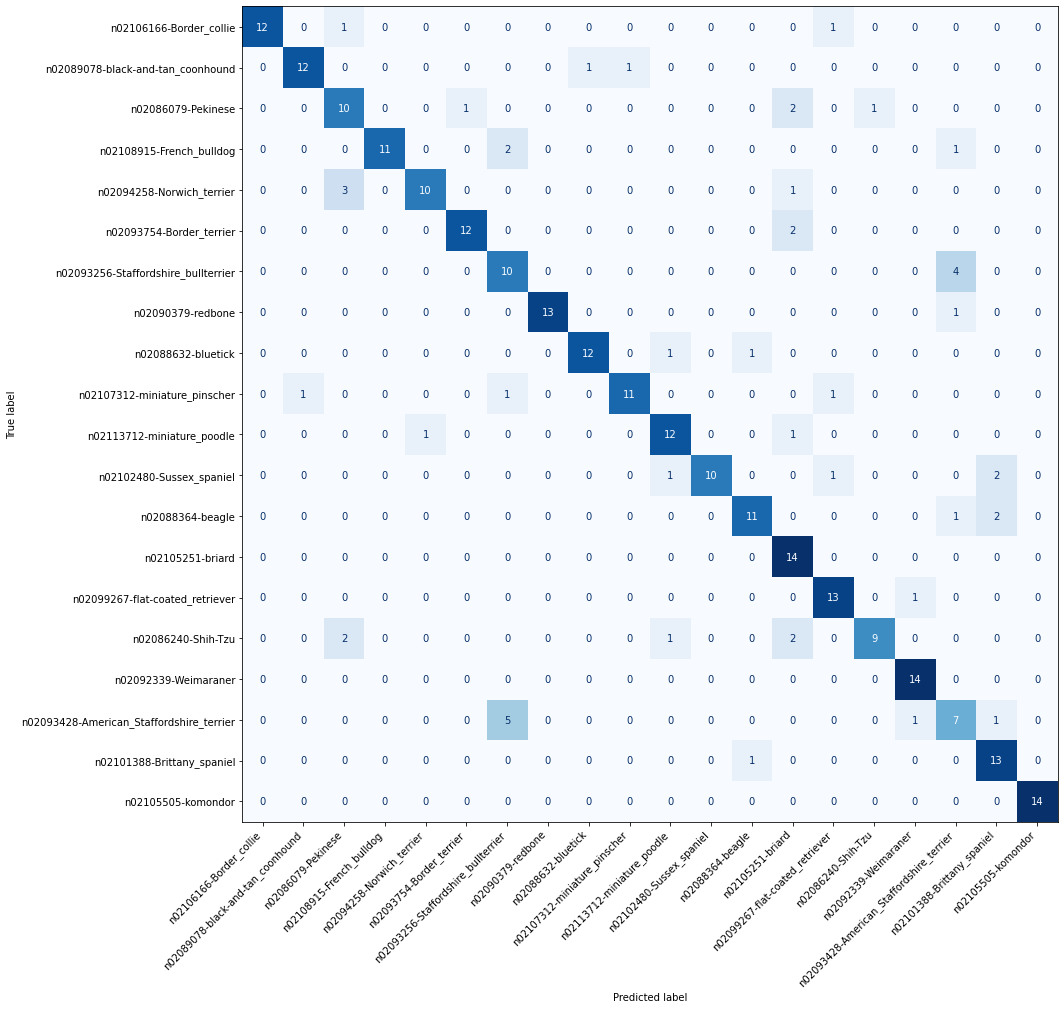

In [34]:
plot_confusion_matrix(test_batches, model, figsize=(15,15))